In [1]:
import sys
sys.path.insert(0, '/home/tim/Classes/CS535/PlanarGrasping/')
# sys.path.insert(0, '/home/tim/Classes/CS535/PlanarGrasping/network/')

import pickle
import matplotlib.pyplot as plt

from grasp_network.model import net, data_loader
from grasp_network import utils
import numpy as np

from data_generation.utils import plot_shape
from data_generation.training_ex import glob_to_loc
from shapely.geometry import Polygon

from IPython import display
%matplotlib inline

import torch

import torch.optim as optim

In [3]:
json_path = '/home/tim/Classes/CS535/PlanarGrasping/grasp_network/experiments/sdf_cnn/params.json'
params = utils.Params(json_path)
params.cuda = torch.cuda.is_available()

data_dir = '/home/tim/Classes/CS535/PlanarGrasping/grasp_network/data'

# fetch dataset
ds = data_loader.SDFDataset('/home/tim/Classes/CS535/PlanarGrasping/grasp_network/data/val')

# Define the model and optimizer
model = net.Net(params).cuda()
optimizer = optim.Adam(model.parameters(), lr=params.learning_rate)

model.eval()

# # reload weights from restore_file if specified
weight_file = '/home/tim/Classes/CS535/PlanarGrasping/grasp_network/experiments/sdf_cnn/best.pth.tar'
checkpoint = torch.load(weight_file)
_ = utils.load_checkpoint(weight_file, model, optimizer)


Opening Dataset from /home/tim/Classes/CS535/PlanarGrasping/grasp_network/data/val/val_examples.p


In [4]:
examples = pickle.load(open('/home/tim/Classes/CS535/PlanarGrasping/grasp_network/data/val/val_examples.p', 'rb'))

0
First scan point: [ 6.72863661 -1.19230029]
Starting to plot!


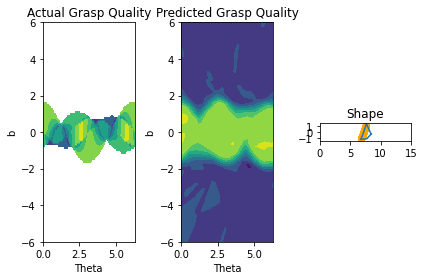

500
First scan point: [ 7.01797776 -1.18927275]
Starting to plot!


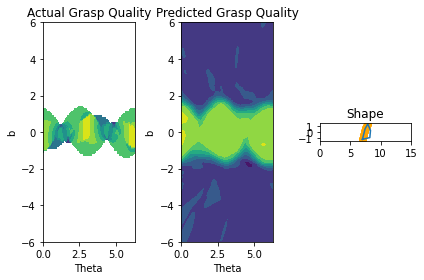

1000
First scan point: [ 9.00991284 -1.35828886]
Starting to plot!


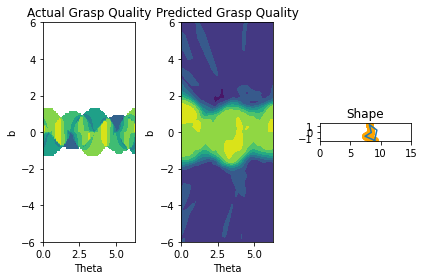

1500
First scan point: [ 6.48147812 -0.66213575]


KeyboardInterrupt: 

In [14]:
for i in range(0,len(ds),500):
    print(i)
    train_batch, labels_batch = ds[i]

    scan_pts = train_batch[:-1,:]

    print(f"First scan point: {scan_pts[0,:]}")


    for ex in examples:
        if np.array_equal(ex[0], scan_pts):
            te = ex[6]
            break

    # print predicted and ground truth grasp quality
    thetas = np.linspace(0, 2*np.pi, 100)
    bs = np.linspace(-6, 6, 100)


    # Map out the actual/pred grasp quality across a grid
    pred_qualities = np.nan * np.ones((100, 100))
    act_qualities = np.nan * np.ones((100,100))
    for j, theta in enumerate(thetas):
        for i, b in enumerate(bs):
            grasp_inp = np.array([theta, b])

            # predict with NN
            inp = np.vstack([scan_pts, grasp_inp])
            inp = torch.Tensor(inp).contiguous().unsqueeze(0)
            s = inp.cuda()
            q = model.forward(s).cpu().detach().numpy()
            pred_qualities[i, j] = q

            # ground-truth quality
            try:
                act_q = te.grasp_quality(theta, b)
                act_qualities[i,j] = act_q
            except ValueError:
                 pass
    
    print("Starting to plot!")
    fig, axs = plt.subplots(1,3)
    axs[0].contourf(thetas, bs, act_qualities)
    axs[0].set_xlabel('Theta')
    axs[0].set_ylabel('b')
    axs[0].set_title('Actual Grasp Quality')

    axs[1].contourf(thetas, bs, pred_qualities)
    axs[1].set_xlabel('Theta')
    axs[1].set_ylabel('b')
    axs[1].set_title('Predicted Grasp Quality')

    coords = np.array(te.shape.exterior.coords)
    loc_shape = Polygon(glob_to_loc(coords, te.robang, te.robx, te.roby))

    plot_shape(loc_shape, axs[2], bounds=[3,12, -2, 2])
    axs[2].scatter(te.scan_pts[:,0], te.scan_pts[:,1], color='orange')
    fig.tight_layout()
    plt.savefig(f'figs/grasp_pred/{i}.png')
    plt.pause(0.01)


In [5]:
from data_generation.training_ex import TrainingExample
from shapely.geometry import Polygon

rectangle = Polygon([[-1,0], [1,0], [1,2], [-1, 2]])
te = TrainingExample(-5, 0, rectangle )
te2 = TrainingExample(0, 5, rectangle )

Starting to plot!


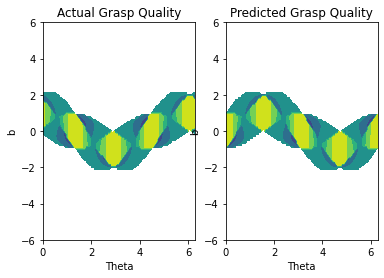

In [6]:
thetas = np.linspace(0, 2*np.pi, 100)
bs = np.linspace(-6, 6, 100)

act_qualities = np.nan * np.ones((100,100))
act_qualities2 = np.nan * np.ones((100,100))
for j, theta in enumerate(thetas):
    for i, b in enumerate(bs):

        try:
            act_q = te.grasp_quality(theta, b)
            act_qualities[i,j] = act_q
        except ValueError:
                pass

        try:
            act_q = te2.grasp_quality(theta, b)
            act_qualities2[i,j] = act_q
        except ValueError:
                pass

        


print("Starting to plot!")
fig, axs = plt.subplots(1,2)
axs[0].contourf(thetas, bs, act_qualities)
axs[0].set_xlabel('Theta')
axs[0].set_ylabel('b')
axs[0].set_title('Actual Grasp Quality')

axs[1].contourf(thetas, bs, act_qualities2)
axs[1].set_xlabel('Theta')
axs[1].set_ylabel('b')
axs[1].set_title('Predicted Grasp Quality')
plt.pause(0.01)

In [89]:
# Create a regular grid of 2D sample points
x = torch.linspace(0, 15, 10)
y = torch.linspace(-5, 5, 10)
X, Y = torch.meshgrid(x, y)
query_pts = torch.column_stack((X.ravel(), Y.ravel())) # Put the grid in an Nx2 matrix
num_query_pts = query_pts.shape[0]

In [124]:
query_pts = torch.flatten(query_pts).unsqueeze(0)
query_pts = query_pts.expand(1, 1, 200)
print(query_pts.shape)

tpts = torch.Tensor(scan_pts).unsqueeze(0)
tpts = torch.tile(tpts, (1, num_query_pts)) # Copy the scan points many times
print(tpts.shape)
# print(query_pts.unsqueeze(0).shape)
# mtx = torch.vstack(( # Stack each repeated scan matrix on top of a 2D query pt
#     tpts,
#     query_pts
# ))
mtx = torch.cat((
    tpts,
    query_pts), dim=-2)
print(mtx)
print(mtx.shape)
# Turn the extra-wide repeated matrix into a 3-d matrix that can be fed
# into a nn.Module
mtx = torch.swapaxes(mtx, -1, -2)
print(mtx)
mtx = torch.reshape(mtx, (-1, num_query_pts, 2, mtx.shape[-1]))
mtx = torch.swapaxes(mtx, -1, -2)
mtx
print(mtx.shape)

torch.Size([1, 1, 200])
torch.Size([1, 100, 200])
tensor([[[ 7.0180, -1.1893,  7.0180,  ..., -1.1893,  7.0180, -1.1893],
         [ 7.0239, -1.1658,  7.0239,  ..., -1.1658,  7.0239, -1.1658],
         [ 7.0299, -1.1423,  7.0299,  ..., -1.1423,  7.0299, -1.1423],
         ...,
         [ 7.8772,  1.3074,  7.8772,  ...,  1.3074,  7.8772,  1.3074],
         [ 7.8937,  1.3377,  7.8937,  ...,  1.3377,  7.8937,  1.3377],
         [ 0.0000, -5.0000,  0.0000,  ...,  3.8889, 15.0000,  5.0000]]])
torch.Size([1, 101, 200])
tensor([[[ 7.0180,  7.0239,  7.0299,  ...,  7.8772,  7.8937,  0.0000],
         [-1.1893, -1.1658, -1.1423,  ...,  1.3074,  1.3377, -5.0000],
         [ 7.0180,  7.0239,  7.0299,  ...,  7.8772,  7.8937,  0.0000],
         ...,
         [-1.1893, -1.1658, -1.1423,  ...,  1.3074,  1.3377,  3.8889],
         [ 7.0180,  7.0239,  7.0299,  ...,  7.8772,  7.8937, 15.0000],
         [-1.1893, -1.1658, -1.1423,  ...,  1.3074,  1.3377,  5.0000]]])
torch.Size([1, 100, 101, 2])


In [79]:
cat = torch.transpose(mtx, 1, 0)
cat = torch.reshape(cat, (num_query_pts, 2, mtx.shape[0]))
cat = torch.swapaxes(cat, 1, 2)
cat

torch.Size([100, 2, 101])


tensor([[[ 7.0180, -1.1893],
         [ 7.0239, -1.1658],
         [ 7.0299, -1.1423],
         ...,
         [ 7.8772,  1.3074],
         [ 7.8937,  1.3377],
         [ 0.0000, -5.0000]],

        [[ 7.0180, -1.1893],
         [ 7.0239, -1.1658],
         [ 7.0299, -1.1423],
         ...,
         [ 7.8772,  1.3074],
         [ 7.8937,  1.3377],
         [ 0.0000, -3.8889]],

        [[ 7.0180, -1.1893],
         [ 7.0239, -1.1658],
         [ 7.0299, -1.1423],
         ...,
         [ 7.8772,  1.3074],
         [ 7.8937,  1.3377],
         [ 0.0000, -2.7778]],

        ...,

        [[ 7.0180, -1.1893],
         [ 7.0239, -1.1658],
         [ 7.0299, -1.1423],
         ...,
         [ 7.8772,  1.3074],
         [ 7.8937,  1.3377],
         [15.0000,  2.7778]],

        [[ 7.0180, -1.1893],
         [ 7.0239, -1.1658],
         [ 7.0299, -1.1423],
         ...,
         [ 7.8772,  1.3074],
         [ 7.8937,  1.3377],
         [15.0000,  3.8889]],

        [[ 7.0180, -1.1893],
       

In [63]:
torch.reshape(mtx, (mtx.shape[0], 2, num_query_pts))

tensor([[[ 7.0180, -1.1893,  7.0180,  ..., -1.1893,  7.0180, -1.1893],
         [ 7.0180, -1.1893,  7.0180,  ..., -1.1893,  7.0180, -1.1893]],

        [[ 7.0239, -1.1658,  7.0239,  ..., -1.1658,  7.0239, -1.1658],
         [ 7.0239, -1.1658,  7.0239,  ..., -1.1658,  7.0239, -1.1658]],

        [[ 7.0299, -1.1423,  7.0299,  ..., -1.1423,  7.0299, -1.1423],
         [ 7.0299, -1.1423,  7.0299,  ..., -1.1423,  7.0299, -1.1423]],

        ...,

        [[ 7.8772,  1.3074,  7.8772,  ...,  1.3074,  7.8772,  1.3074],
         [ 7.8772,  1.3074,  7.8772,  ...,  1.3074,  7.8772,  1.3074]],

        [[ 7.8937,  1.3377,  7.8937,  ...,  1.3377,  7.8937,  1.3377],
         [ 7.8937,  1.3377,  7.8937,  ...,  1.3377,  7.8937,  1.3377]],

        [[ 0.0000, -5.0000,  0.0000,  ...,  3.8889,  6.6667,  5.0000],
         [ 8.3333, -5.0000,  8.3333,  ...,  3.8889, 15.0000,  5.0000]]])

In [43]:
torch.reshape(mtx, (num_query_pts, mtx.shape[0], 2))

tensor([[[ 7.0180, -1.1893],
         [ 7.0180, -1.1893],
         [ 7.0180, -1.1893],
         ...,
         [ 7.0180, -1.1893],
         [ 7.0180, -1.1893],
         [ 7.0239, -1.1658]],

        [[ 7.0239, -1.1658],
         [ 7.0239, -1.1658],
         [ 7.0239, -1.1658],
         ...,
         [ 7.0239, -1.1658],
         [ 7.0299, -1.1423],
         [ 7.0299, -1.1423]],

        [[ 7.0299, -1.1423],
         [ 7.0299, -1.1423],
         [ 7.0299, -1.1423],
         ...,
         [ 7.0358, -1.1188],
         [ 7.0358, -1.1188],
         [ 7.0358, -1.1188]],

        ...,

        [[ 7.8607,  1.2773],
         [ 7.8607,  1.2773],
         [ 7.8607,  1.2773],
         ...,
         [ 7.8772,  1.3074],
         [ 7.8772,  1.3074],
         [ 7.8772,  1.3074]],

        [[ 7.8772,  1.3074],
         [ 7.8772,  1.3074],
         [ 7.8937,  1.3377],
         ...,
         [ 7.8937,  1.3377],
         [ 7.8937,  1.3377],
         [ 7.8937,  1.3377]],

        [[ 7.8937,  1.3377],
       